# Notebook 2: Minimal Transformer Encoder Block

In this notebook, you'll:
- Build a minimal Transformer encoder block (LayerNorm, Multi-Head Attention, MLP)
- Add residual connections
- Run a forward pass on synthetic data
- Inspect shapes and parameters
- Optionally evaluate on MNIST patches to verify end-to-end


In [1]:
# Imports and config
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

HIDDEN_DIM = 128
INTERMEDIATE_DIM = 256
NUM_HEADS = 4


In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int):
        super().__init__()
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.W_Q = nn.Linear(hidden_dim, hidden_dim)
        self.W_K = nn.Linear(hidden_dim, hidden_dim)
        self.W_V = nn.Linear(hidden_dim, hidden_dim)
        self.W_O = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, length, hidden_dim)
        batch = x.size(0)
        L = x.size(1)

        Q = self.W_Q(x).view(batch, L, self.num_heads, self.head_dim).transpose(1, 2)  # (b, h, L, d_h)
        K = self.W_K(x).view(batch, L, self.num_heads, self.head_dim).transpose(1, 2)  # (b, h, L, d_h)
        V = self.W_V(x).view(batch, L, self.num_heads, self.head_dim).transpose(1, 2)  # (b, h, L, d_h)

        attn_logits = Q @ K.transpose(-1, -2) / math.sqrt(self.head_dim)               # (b, h, L, L)
        attn = F.softmax(attn_logits, dim=-1)
        H = attn @ V                                                                  # (b, h, L, d_h)
        H = H.transpose(1, 2).contiguous().view(batch, L, self.hidden_dim)            # (b, L, d)
        return self.W_O(H)


In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_dim: int, intermediate_dim: int):
        super().__init__()
        self.w1 = nn.Linear(hidden_dim, intermediate_dim)
        self.w2 = nn.Linear(intermediate_dim, hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(F.gelu(self.w1(x)))


In [4]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, hidden_dim: int, intermediate_dim: int, num_heads: int):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.mha = MultiHeadAttention(hidden_dim, num_heads)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.mlp = MLP(hidden_dim, intermediate_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pre-norm
        h = x + self.mha(self.ln1(x))
        h = h + self.mlp(self.ln2(h))
        return h


In [5]:
# Synthetic data forward pass
batch, length = 4, 32
x = torch.randn(batch, length, HIDDEN_DIM)
block = TransformerEncoderBlock(HIDDEN_DIM, INTERMEDIATE_DIM, NUM_HEADS)
y = block(x)
print('Input:', x.shape, 'Output:', y.shape)


Input: torch.Size([4, 32, 128]) Output: torch.Size([4, 32, 128])


In [6]:
# Optional: MNIST patch embedding + one encoder block
IMG_SIZE = 28
PATCH = 7
TOKENS = (IMG_SIZE // PATCH) * (IMG_SIZE // PATCH)  # 16

mean, std = 0.1307, 0.3081
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

test_ds = datasets.MNIST('../data/MNIST/', train=False, download=True, transform=transform)
img, label = test_ds[0]

# Patchify to tokens of dim 49 and project to hidden size

def image_to_patches(x: torch.Tensor, patch: int = PATCH):
    c, h, w = x.shape
    x = x.unfold(1, patch, patch).unfold(2, patch, patch)  # (1, 4, 4, 7, 7)
    x = x.contiguous().view(c, -1, patch*patch).transpose(0, 1)  # (16, 49)
    return x

patches = image_to_patches(img)  # (16, 49)
proj = nn.Linear(PATCH*PATCH, HIDDEN_DIM)
with torch.no_grad():
    tokens = proj(patches)              # (16, HIDDEN_DIM)
    tokens = tokens.unsqueeze(0)        # (1, 16, HIDDEN_DIM)
    block = TransformerEncoderBlock(HIDDEN_DIM, INTERMEDIATE_DIM, NUM_HEADS)
    y = block(tokens)
    pooled = y.mean(dim=1)              # (1, HIDDEN_DIM)

print('Tokens:', tokens.shape, 'Encoded:', y.shape, 'Pooled:', pooled.shape, 'Label:', label)


Tokens: torch.Size([1, 16, 1, 128]) Encoded: torch.Size([1, 16, 16, 128]) Pooled: torch.Size([1, 16, 128]) Label: 7


## Intuition and design choices
- Pre-norm improves optimization stability for deeper stacks.
- LayerNorm normalizes features per token; residuals preserve information flow.
- Multi-Head splits the space to attend to different patterns in parallel.
- MLP expands features nonlinearly; GELU is commonly used.


In [7]:
# Sinusoidal positional encoding (PE)

def sinusoidal_position_encoding(length: int, dim: int):
    pos = torch.arange(length).unsqueeze(1)           # (L,1)
    i = torch.arange(dim).unsqueeze(0)                # (1,d)
    angle_rates = 1 / torch.pow(10000, (2*(i//2))/dim)
    angles = pos * angle_rates                        # (L,d)
    pe = torch.zeros(length, dim)
    pe[:, 0::2] = torch.sin(angles[:, 0::2])
    pe[:, 1::2] = torch.cos(angles[:, 1::2])
    return pe

# Demonstrate symmetry breaking with PE
batch, length = 1, 16
x = torch.zeros(batch, length, HIDDEN_DIM)           # identical tokens
block = TransformerEncoderBlock(HIDDEN_DIM, INTERMEDIATE_DIM, NUM_HEADS)

with torch.no_grad():
    y_nope = block(x)
    pe = sinusoidal_position_encoding(length, HIDDEN_DIM).unsqueeze(0)
    y_pe = block(x + pe)

print('Without PE std:', y_nope.std().item())
print('With PE std   :', y_pe.std().item())


Without PE std: 0.16249534487724304
With PE std   : 0.6424624919891357


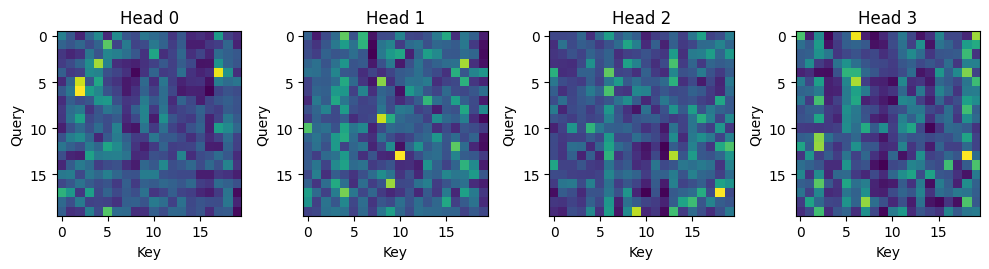

In [8]:
# Visualize one head's attention on toy tokens

def get_attention_weights(mha: MultiHeadAttention, x: torch.Tensor):
    with torch.no_grad():
        batch = x.size(0); L = x.size(1)
        Q = mha.W_Q(x).view(batch, L, mha.num_heads, mha.head_dim).transpose(1, 2)
        K = mha.W_K(x).view(batch, L, mha.num_heads, mha.head_dim).transpose(1, 2)
        logits = Q @ K.transpose(-1, -2) / math.sqrt(mha.head_dim)
        W = F.softmax(logits, dim=-1)
        return W

length = 20
x = torch.randn(1, length, HIDDEN_DIM)
pe = sinusoidal_position_encoding(length, HIDDEN_DIM).unsqueeze(0)
block = TransformerEncoderBlock(HIDDEN_DIM, INTERMEDIATE_DIM, NUM_HEADS)
W = get_attention_weights(block.mha, x + pe)          # (1, heads, L, L)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, min(NUM_HEADS, 4), figsize=(10,3))
for h in range(min(NUM_HEADS, 4)):
    axes[h].imshow(W[0, h].numpy(), cmap='viridis')
    axes[h].set_title(f'Head {h}')
    axes[h].set_xlabel('Key'); axes[h].set_ylabel('Query')
plt.tight_layout(); plt.show()


### Exercises
- Switch to post-norm and compare training stability on a small task.
- Add Dropout to attention weights and MLP layer; observe effects.
- Stack 2–3 encoder blocks and measure parameter growth and speed.
- Try different head counts while keeping hidden_dim fixed.
